In [555]:
# !pip install torch_geometric

In [556]:
from torch_geometric.datasets import QM9
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import torch
from random import randint

In [557]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [558]:
device

device(type='cuda')

In [559]:
dataset = QM9(root="./dataset/")

In [560]:
data = dataset.data
print(data)
print(dataset.num_features)
print(dataset.num_classes)
print(len(dataset))

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])
11
19
130831


In [561]:
# dataset.print_summary()
target = 6 # Setting zero point vibrational energy as the target variable.
dataset.y = dataset.y[:, target]
dataset.y = (dataset.y - dataset.y.mean()) / dataset.y.std()
dataset.x = (dataset.x - dataset.x.mean(dim=0)) / dataset.x.std(dim=0)

In [562]:
dataset.x[0]

tensor([-1.0248,  1.3549, -0.2439, -0.2902, -0.0359,  0.8464,     nan,     nan,
            nan,     nan,  4.0475])

In [563]:
dataset.y[0]

tensor(-3.1487)

In [564]:
dataset.num_classes

19

In [565]:
def plot_graph(graph_data):
    graph = to_networkx(graph_data, to_undirected=True)

    def visualize_graph(G):
        plt.figure(figsize=(7,7))
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True)
        plt.show()

    visualize_graph(graph)

torch.Size([22, 11])
torch.Size([1, 19])


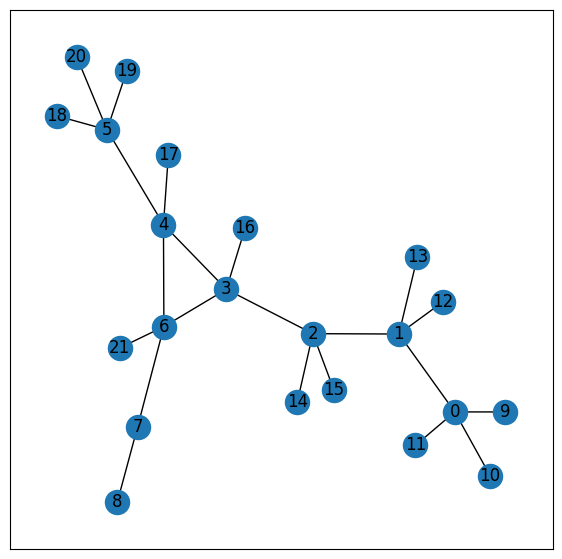

torch.Size([16, 11])
torch.Size([1, 19])


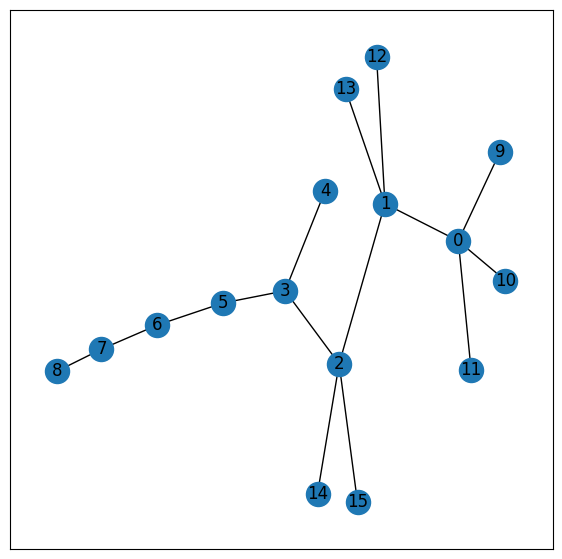

torch.Size([23, 11])
torch.Size([1, 19])


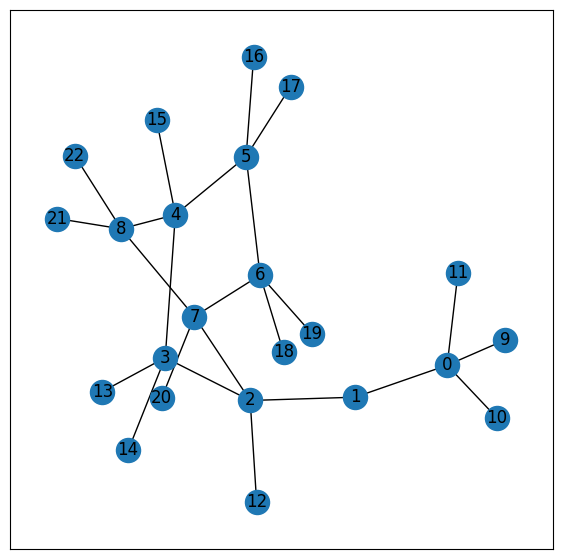

torch.Size([20, 11])
torch.Size([1, 19])


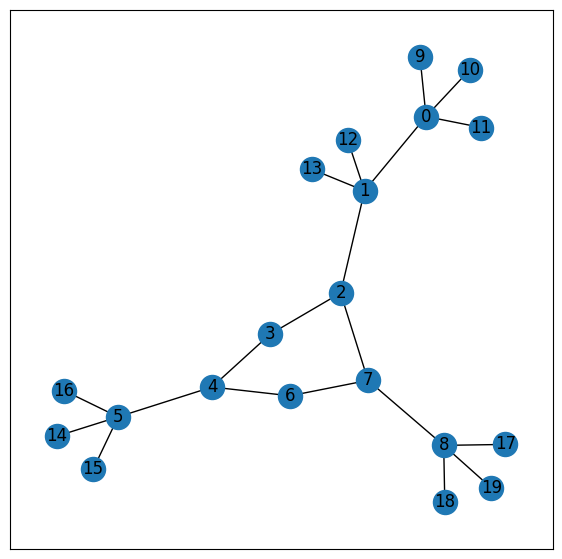

torch.Size([20, 11])
torch.Size([1, 19])


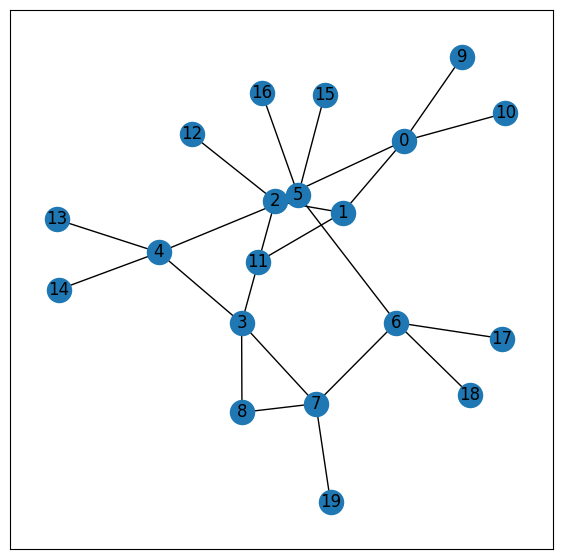

In [566]:
for _ in range(0, 5):
    idx = randint(0, len(dataset) - 1)
    data = dataset[idx]
    print(data.x.shape)
    print(data.y.shape)
    plot_graph(data)

In [567]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=False)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize=False)
        self.conv3 = GCNConv(hidden_channels, hidden_channels, normalize=False)
        self.lin1 = Linear(hidden_channels, out_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.dropout = Dropout(p=0.4)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        return x

In [568]:
dataset = dataset[:100]

In [569]:
train_dataset = dataset[:80]
val_dataset = dataset[80:90]
test_dataset = dataset[90:]
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [570]:
train_losses = []
val_losses = []
test_losses = []

In [571]:
def plot_losses():
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.legend()
    plt.show()

In [572]:
@torch.no_grad()
def validate(model, mse):
    model.eval()
    total_val_loss = 0

    for batch in val_loader:
        batch = batch.to(device)
        outputs = model(batch)
        val_loss = mse(outputs, batch.y)
        total_val_loss += val_loss.item()

    val_losses.append(total_val_loss / len(val_loader))

    return total_val_loss / len(val_loader)

In [573]:
def train(model, optimizer, mse):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = mse(outputs, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_losses.append(loss.item())

    val_loss = validate(model, mse)

    return total_loss / len(train_loader), val_loss

In [574]:
@torch.no_grad()
def test(model, mse):
    model.eval()
    total_loss = 0
    for batch in test_loader:
        batch = batch.to(device)
        prediction = model(batch)
        loss = mse(prediction, batch.y)
        total_loss += loss.item()
        test_losses.append(loss.item())

    return total_loss / len(train_loader)

In [575]:
gcn = GCN(in_channels=dataset.num_features, hidden_channels=32, out_channels=1).to(device)
# gat = GAT(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
# sage = SAGEConv(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)

In [576]:
models = [gcn]

In [577]:
for model in models:
    # compiled = model.compile()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mse = torch.nn.MSELoss()
    for epoch in range(500):
        train_loss, val_loss = train(model, optimizer, mse)
        print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
    testing_loss = test(model, mse)
    print(f"Testing Loss: {testing_loss}")

Epoch: 0, Training Loss: 6408403.35, Validation Loss: 8796152.0
Epoch: 1, Training Loss: 6406679.2, Validation Loss: 8795369.0
Epoch: 2, Training Loss: 6404860.05, Validation Loss: 8794655.0
Epoch: 3, Training Loss: 6402448.45, Validation Loss: 8793010.0
Epoch: 4, Training Loss: 6399343.35, Validation Loss: 8790629.0
Epoch: 5, Training Loss: 6395897.05, Validation Loss: 8787706.0
Epoch: 6, Training Loss: 6391402.85, Validation Loss: 8785593.0
Epoch: 7, Training Loss: 6386842.65, Validation Loss: 8783456.0
Epoch: 8, Training Loss: 6380963.2, Validation Loss: 8773657.0
Epoch: 9, Training Loss: 6374390.9, Validation Loss: 8761287.0
Epoch: 10, Training Loss: 6366481.95, Validation Loss: 8737719.0
Epoch: 11, Training Loss: 6359242.55, Validation Loss: 8731981.0
Epoch: 12, Training Loss: 6348042.55, Validation Loss: 8725284.0
Epoch: 13, Training Loss: 6339012.625, Validation Loss: 8698473.0
Epoch: 14, Training Loss: 6327438.275, Validation Loss: 8651666.0
Epoch: 15, Training Loss: 6315749.45

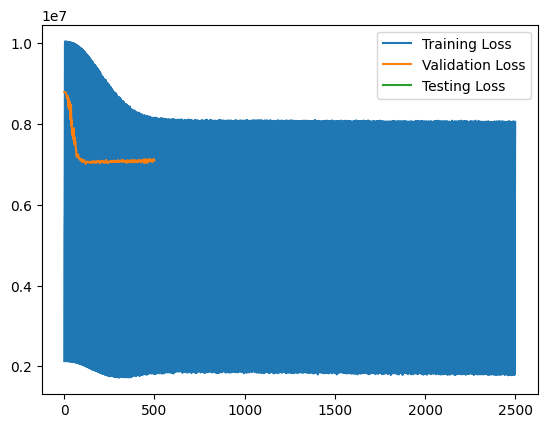

In [578]:
plot_losses()